<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание</a></span></li><li><span><a href="#Импорт,-анализ-и-предобработка-данных" data-toc-modified-id="Импорт,-анализ-и-предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт, анализ и предобработка данных</a></span></li><li><span><a href="#Содание-дополнительных-признаков-данных" data-toc-modified-id="Содание-дополнительных-признаков-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Содание дополнительных признаков данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Dummy-Regressor" data-toc-modified-id="Dummy-Regressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dummy Regressor</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Light-GMB-(бустинг)" data-toc-modified-id="Light-GMB-(бустинг)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Light GMB (бустинг)</a></span></li><li><span><a href="#Вывод:-обучение-и-выбор-моделей" data-toc-modified-id="Вывод:-обучение-и-выбор-моделей-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод: обучение и выбор моделей</a></span></li></ul></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Общий-итог" data-toc-modified-id="Общий-итог-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий итог</a></span></li></ul></div>

# Проект: Прогнозирование заказов такси

## Описание

**Описание задачи**

На основании исторических данных о заказах такси в зависимости от времени - необходимо построить модель предсказания заказов такси на следующий час

___

**Имеющиеся данные**

Исторические данные о заказах такси с временем заказа

* `datetime` - дата и время заказов
* `[целевой] num_orders` - количество заказов

___

**Критерии оценки качества модели**

Значение метрики RMSE на тестовой выборке должно быть не более 48.

___

**План выполнения проекта**

* Проанализировать и предобработать данные
* Построить модели, подходящие для работы с временными рядами
* Выбрать модель, отвечающую критериям качества

___

## Импорт, анализ и предобработка данных

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgbm
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
path_on = '/datasets/taxi.csv'
path_of = 'taxi.csv'

if os.path.exists(path_on):
    df = pd.read_csv(path_on)
elif os.path.exists(path_of):
    df = pd.read_csv(path_of)
else:
    print('Check path to source file')

___

In [3]:
#general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


* Количество объектов в данных - 26 496
* Признак только один - дата и время

In [4]:
df.head(3)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


Данные в столбце `datetime` (время и дата) имеют формат object - переведем в формат datetime

In [5]:
#covert datetime format
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Формат в столбце `datetime` изменен на datetime

___

In [7]:
#check duplicates
df.duplicated().sum()

0

In [8]:
#check missing values
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Проверка на неявные дубликаты - все записи должны быть уникальны в столбце `datetime`

In [9]:
#check hidden duplicates
len(df['datetime'].unique()) == df.shape[0]

True

Пропуски и дублирующиеся значения отсутствуют

___

Сделаем индексом столбец с датой и временем, а также отсортируем по возрастанию

In [10]:
#change index to datetime column
try:
    df = df.set_index('datetime')
except:
    pass
df.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [11]:
#sort ascending
df = df.sort_index()

In [12]:
#check max, min and lower and upper values
print(df.index.min() == df.index[0])
print(df.index.max() == df.index[-1])

True
True


Данные отсортированы

___

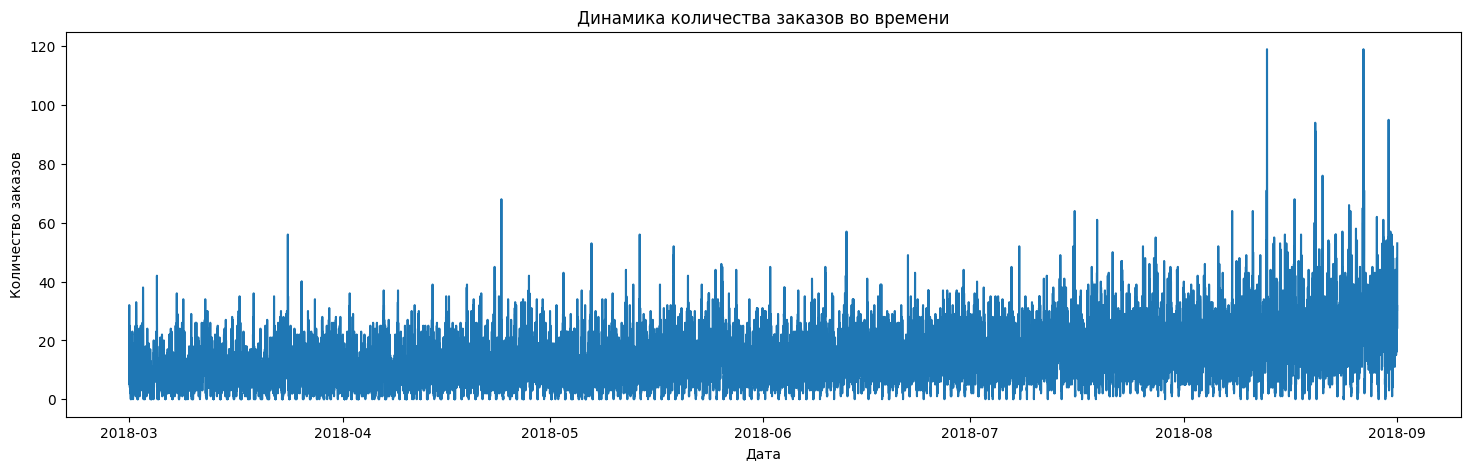

In [13]:
#plot data
plt.figure(figsize=(18,5))
plt.plot(df)
plt.title('Динамика количества заказов во времени')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

plt.show()

In [14]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:50:00


* Имеются данные за период с 01 марта 2018 00.00 по 31 августа 2018 23.50
* Похоже, что интервал в данных = 10 минут

Сгруппируем данные: просуммируем количество заказов за каждый час

In [15]:
#resample data by 1 hour
df_resampled = df.resample('1H').sum()

In [16]:
#check resampled
df_resampled.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [17]:
df_resampled.shape

(4416, 1)

* Данные сгруппированы по интервалу - 1 час.
* Новое количество объектов после группировки - 4 416

___

Проведем анализ на тренд, сезонность и шум

In [18]:
decomposed = seasonal_decompose(df_resampled)

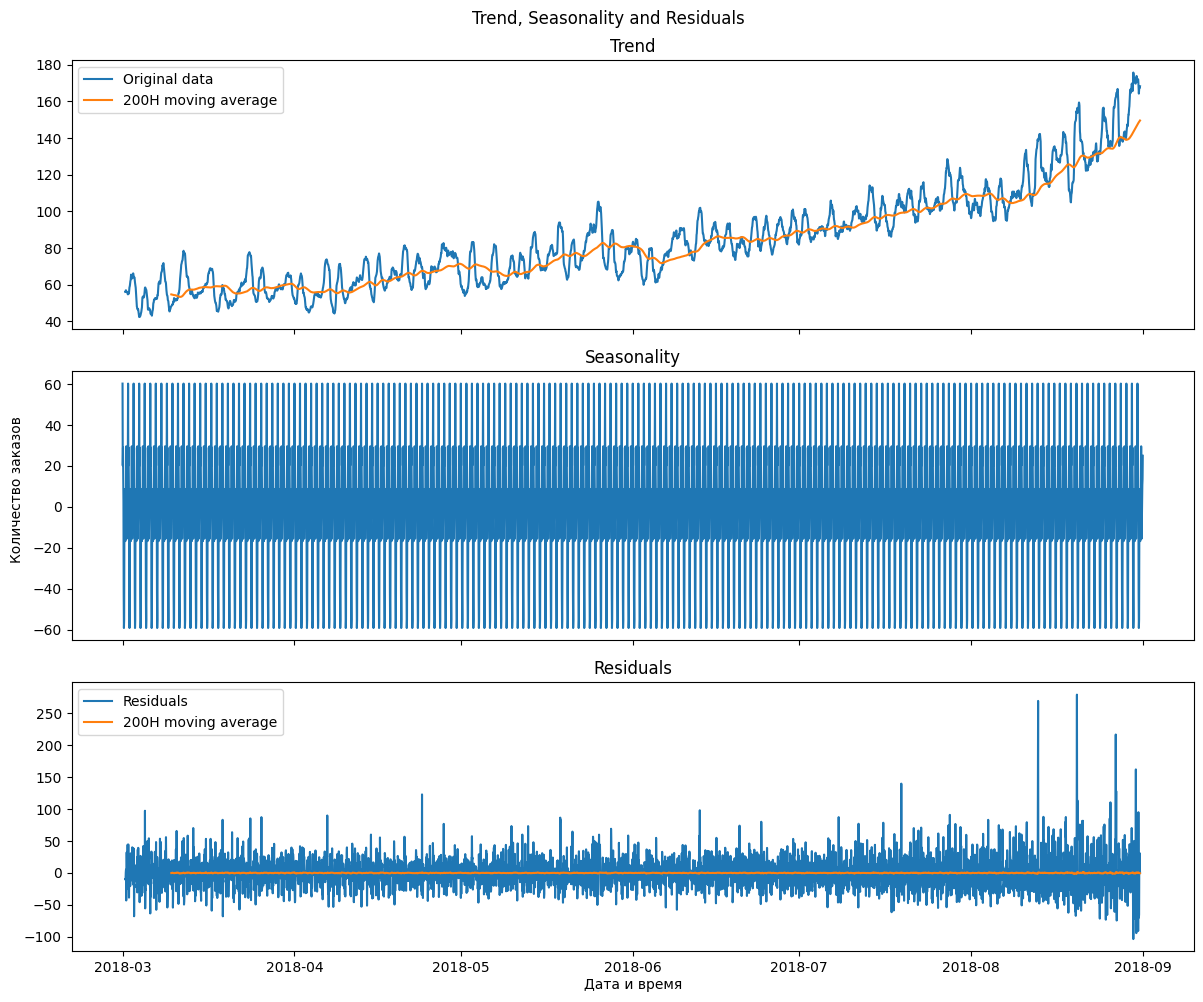

In [19]:
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True)
fig.suptitle('Trend, Seasonality and Residuals')

ax[0].plot(decomposed.trend)
ax[0].plot(decomposed.trend.dropna().rolling(200).mean())
ax[0].set_title('Trend')
ax[0].legend(['Original data', '200H moving average'])

ax[1].plot(decomposed.seasonal)
ax[1].set_title('Seasonality')

ax[2].plot(decomposed.resid)
ax[2].plot(decomposed.resid.dropna().rolling(200).mean())
ax[2].set_title('Residuals')
ax[2].legend(['Residuals', '200H moving average'])

fig.text(0.52, 0.001, 'Дата и время', ha='center')
fig.text(0.001, 0.5, 'Количество заказов', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

Дополнительно, чтобы проверить стационарность, проведем тест Дики-Фуллера

In [20]:
result = adfuller(df_resampled, autolag='AIC')

print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["1%"]:
    print ("Проверка для критического уровня 1%: Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Проверка для критического уровня 1%: Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

    
if result[0] < result[4]["5%"]:
    print ("Проверка для критического уровня 5%: Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Проверка для критического уровня 5%: Нулевая гипотеза не отвергнута – Временной ряд не стационарен")    

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Проверка для критического уровня 1%: Нулевая гипотеза не отвергнута – Временной ряд не стационарен
Проверка для критического уровня 5%: Нулевая гипотеза отвергнута – Временной ряд стационарен


**Выводы**

* Наблюдается явный тренд на увеличение количества заказов на протяжении всего объема данных
* Наблюдается сезонность
* В части шума при построении скользящего среднего видно, что среднее не изменяется, поэтому на этом основании можно сделать вывод, что ряд стационарен (относительно тренда и сезонности)

* Также при проведении проверки на стационарность методом Дики-Фуллера, мы получили следующие результаты:
    * при установлении критического уровня, равного 5% - ряд стационарен
    * при установлении критичесного уровня, равного 1% - рад не стационарен
* Это говорит о том, что точность моделирования будет ниже, чем если бы временной ряд был стационарен при обоих критериях значимости.

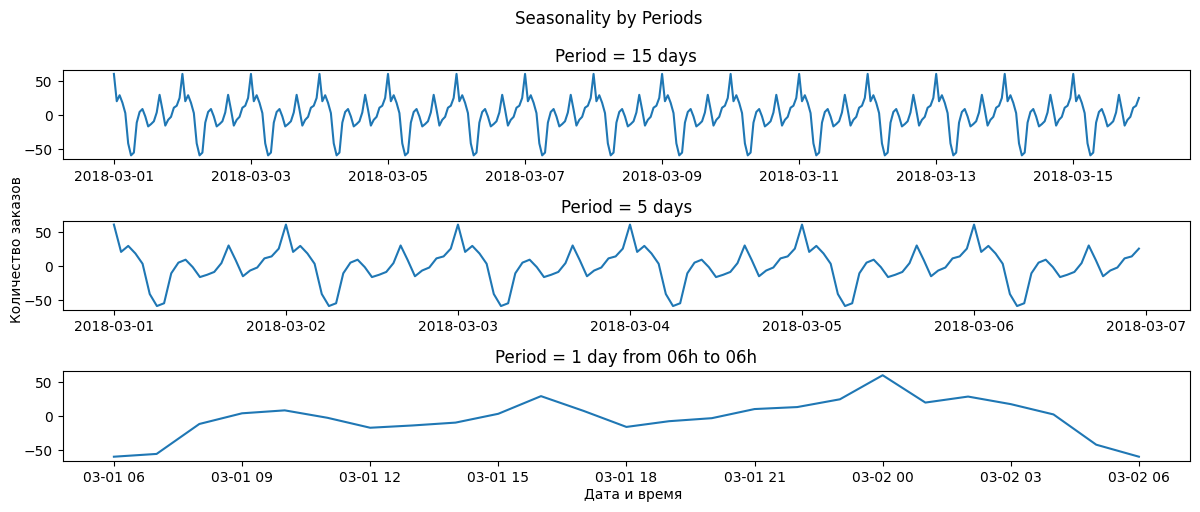

In [21]:
fig, ax = plt.subplots(3,1, figsize=(12,5))
fig.suptitle('Seasonality by Periods')

ax[0].plot(decomposed.seasonal['2018-03-01':'2018-03-15'])
ax[0].set_title('Period = 15 days')

ax[1].plot(decomposed.seasonal['2018-03-01':'2018-03-06'])
ax[1].set_title('Period = 5 days')

ax[2].plot(decomposed.seasonal['2018-03-01 06:00:00':'2018-03-02 06:00:00'])
ax[2].set_title('Period = 1 day from 06h to 06h')

fig.text(0.52, 0.001, 'Дата и время', ha='center')
fig.text(0.001, 0.5, 'Количество заказов', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

**Вывод**

Видно, что наблюдается явная сезонность:
* ежедневно количество заказов растет с 06 утра и достигает максимума к полуночи (00:00), затем происходит резкий спад
* это может быть обусловлено несколькими факторами:
    * пассажиры стараются прилетать ближе к вечеру, потому что так удобнее, и меньше - ночью
    * в дневные часы пассажиры пользуются публичным транспортом, поэтому заказов ниже

**Общие выводы**

* В данных наблюдается явный тренд (на всем объеме данных) - заказы постоянно растут и сезонность внутри дня (количество заказов растет от 06 утра до полуночи, затем резко спадает в ночное время
* Временной ряд стационарен при уровне значимости, равном 5%.

___

## Содание дополнительных признаков данных

Напишем функцию по генерации дополнительных признаков для обучения моделей:
* получение дня, номера дня недели, часа как отдельных признаков
* получения признаков в соответствии с разными сдвигами данных (данные о днях x-1, x-2, x-3 итд)
* получение скользящих средних по разным периодам

PS:
* так как данные имеются за неполный год, то:
    * признак "год" - не является показательным для обучения модели (одинаковый для всех данных), никакой информации из него извлечь нельзя
    * признак "месяц" - не является показательным для обучения модели, так как в тестовых данных признаки месяца будут отличатся от обучающей выборки

In [22]:
def make_features(df, max_lag, rolling_avg_period):
    
    d = df.copy()
    
    #retreive date, dayoftheweek, hour from date
#    d['year'] = d.index.year
#    d['month'] = d.index.month
    d['day'] = d.index.day
    d['dayofweek'] = d.index.dayofweek
    d['hour'] = d.index.hour
    
    #create lag features
    for i in range(1, max_lag+1):
        d['lag_{}'.format(i)] = d['num_orders'].shift(i)
    
    #create moving average
    d['mov_avg'] = d['num_orders'].shift(1).rolling(rolling_avg_period).mean()
    
    return d

___

## Обучение моделей

### Dummy Regressor

Первая модель - простое предсказание среднего значение

In [23]:
#divide datasets into test, validation and train datasets
X = df_resampled.drop(columns=['num_orders'])
y = df_resampled['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=0, test_size=0.1)

#Initialize
dr = DummyRegressor(strategy="mean")

#fit and predict
dr.fit(X_train, y_train)
predictions = dr.predict(X_train)

#calculate the metric
dr_score = mean_squared_error(y_true=y_train, y_pred=predictions, squared=False)
round(dr_score, 3)

38.667

**Результат**

* Простая базовая модель дает значение метрики RMSE = 38.7

### Линейная регрессия

Путем подбора будем:
* перебирать параметры создания дополнительных признаков
* создавать признаки
* делить данные на обучающую, валидационную и тестовую выборку
* обучать модель линейной регрессии
* считать значение целевой метрики на валидационной выборке
* сохранять все параметры и полученную целевую метрику в словарь

In [24]:
max_lags = []
roll_periods = []
rmse_valid = []

#range shoud start from one (no moving average with value of periods = 0)

for rolling_avg_period in range(1,30):
    for max_lag in range(30):

            #create features
            data = make_features(df_resampled, max_lag, rolling_avg_period)
            
            #drop rows with NaN
            data = data.dropna()

            #divide datasets into test, validation and train datasets
            X = data.drop(columns=['num_orders'])
            y = data['num_orders']
            
            X_train, X_, y_train, y_ = train_test_split(X, y, shuffle=False, random_state=0, test_size=0.2)
            X_valid, X_test, y_valid, y_test = train_test_split(X_, y_, shuffle=False, random_state=0, test_size=0.5)
            
            #initialise the model
            model = LinearRegression()

            #fit the model on train data
            model.fit(X_train, y_train)

            #make predictions
            y_pred = model.predict(X_valid)

            #calculate MAE
            rmse = mean_squared_error(y_true=y_valid, y_pred=y_pred, squared=False)

            #save results
            max_lags.append(max_lag)
            roll_periods.append(rolling_avg_period)
            rmse_valid.append(rmse)

In [25]:
#get index with the lowest value of MAE
min_rmse_idx = rmse_valid.index(min(rmse_valid))

print("Best RMSE:", round(min(rmse_valid),2))
print("Best num_rolling_periods:", roll_periods[min_rmse_idx])
print("Best num_lags:", max_lags[min_rmse_idx])

Best RMSE: 34.33
Best num_rolling_periods: 27
Best num_lags: 25


**Выводы**

Модель регрессии показала на валидационной выборке лучший результат, равный 34.3 при значениях:
* количество шагов во времени = 27
* скользящее среднее за 25 периодов

___

### Light GMB (бустинг)

Построим модель градиентного бустинга Light GBM, зафиксировав количество деревьев, равное 2000. Аналогично будем путем подбора
* перебирать параметры создания дополнительных признаков
* создавать признаки
* делить данные на обучающую и тестовую выборку
* обучать модель градиентного бустинга, проверяя ее с помощью кросс-валидации для временных рядов
* считать значение целевой метрики на кросс-валидации
* сохранять все параметры и полученную целевую метрику в словарь

In [26]:
%%time

#create the dictionary for model hyperparameters
hp = dict(
    max_depth=np.array(range(3,7,1)),
    learning_rate=[0.1, 0.01]
)

max_lags = []
roll_periods = []
rmse_valid = []
best_params = []

#range shoud start from one (no moving average with value of periods = 0)

for rolling_avg_period in range(1,10):
    for max_lag in range(10):

            #create features
            data = make_features(df_resampled, max_lag, rolling_avg_period)
            
            #drop rows with NaN
            data = data.dropna()

            #divide datasets into test, validation and train datasets
            X = data.drop(columns=['num_orders'])
            y = data['num_orders']
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=0, test_size=0.1)

            #initialise the model
            lgbm_reg = lgbm.LGBMRegressor(n_estimators=2000, random_state=0)

            #define cross validation for time series
            tscv = TimeSeriesSplit(n_splits=3)
            
            grid = GridSearchCV(lgbm_reg, hp, cv=tscv, scoring="neg_root_mean_squared_error")
            grid.fit(X_train, 
                     y_train)

            #save results
            max_lags.append(max_lag)
            roll_periods.append(rolling_avg_period)
            rmse_valid.append(grid.best_score_ * -1)
            best_params.append(grid.best_params_)

CPU times: total: 2h 23min 28s
Wall time: 39min 59s


In [27]:
#get index with the lowest value of MAE
min_rmse_idx = rmse_valid.index(min(rmse_valid))

#get the lowest value of MAE
print("Best RMSE:", round(min(rmse_valid),2))
print("Best num_rolling_periods:",  roll_periods[min_rmse_idx])
print("Best num_lags:", max_lags[min_rmse_idx])
print("Best best parameters:", best_params[min_rmse_idx])

Best RMSE: 27.65
Best num_rolling_periods: 1
Best num_lags: 8
Best best parameters: {'learning_rate': 0.01, 'max_depth': 3}


___

**Вывод**

* Градиентный бустинг показал значение метрики лучше (27.65), чем линейная регрессия (34.3) и чем константная модель (38.7), однако, обучаясь существенно дольше.
* Наилучшее значение гиперпараметров и параметров создания дополнительных признаков следующие:
    * период для скользящего среднего = 1
    * количество сдвигов по времени = 8
    * learning_rate = 0.01
    * макс глубина дерева = 3

___

### Вывод: обучение и выбор моделей

* Модели дерева решений и случайного леса не использовали, так как они не подходят для прогнозирования временных рядов
* Построили две модели: линейная регрессия и градиентный бустинг Light GBM
* Градиентный бустинг Light GBM показал лучшие результаты метрики, однако, при существенно более низком времени обучения

В данном случае критерием оценки является только значение метрики RMSE, поэтому выбираем модель градиентного бустинга.

___

## Проверка модели на тестовой выборке

Построим сначала константную модель - предсказание на тестовой выборке среднего по обучающей выборке

In [28]:
#divide datasets into test, validation and train datasets
X = df_resampled.drop(columns=['num_orders'])
y = df_resampled['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=0, test_size=0.1)

#Initialize
dr = DummyRegressor(strategy="mean")

#fit and predict
dr.fit(X_train, y_train)
predictions = dr.predict(X_test)

#calculate the metric
dr_score = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
round(dr_score, 3)

84.744

Построим модель линейной регрессии с полученными на обучении наилучшими параметрами сдвига по времени периода скользащей средней.

In [29]:
#create features
data = make_features(df_resampled, 8, 1)

#drop rows with NaN
data = data.dropna()

#divide datasets into test, validation and train datasets
X = data.drop(columns=['num_orders'])
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=0, test_size=0.1)

#initialise the model
##model = LinearRegression()
lgbm_reg = lgbm.LGBMRegressor(n_estimators=2000, random_state=0, max_depth=3, learning_rate=0.01)

#fit the model on train data
lgbm_reg.fit(X_train, y_train)

#make predictions
y_pred = lgbm_reg.predict(X_test)

#calculate MAE
rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
print('Test RMSE:', rmse)

Test RMSE: 45.04912241088287


**Вывод**

На тестовой выборке получили значение метрики RMSE (45) ниже, чем целевое значение (48), и ниже, чем у константной модели (84.7) поэтому построение модели можно считать успешным.

___

## Общий итог


**Описание**
Необходимо было построить модель, которая предсказывала бы количество заказов такси на следующий час на основании исторических данных о заказах такси

**Выполненные шаги**

* Данные были приведены в необходимый формат для работы с временными рядами
* Далее для обучения моделей создавались дополнительные признаки на основании даты, такие как:
    * год, месяц, день, день недели, час
    * сдвиг по данным на {x-1, x-2,...x-n} дней, где x - текущая дата
    * расчет скользящего среднего на m дней
* Значения n и m подбирались путем подбора и получения наилучшего результата - значение метрики RMSE на валидационной выборке
* Были обучены две модели - линейная регрессия и градиентный бустинг Light GBM
* Наилучший результат на обучении показала модель градиентного бустинга Light GBM, однако, ценой существенно более длительного обучения
* На тестовой выборке выбранная модель также показала удовлетворяющий критериям оценки результат - значение метрики RMSE ниже целевого.